Source:

https://www.geekering.com/categories/computer-vision/marcellacavalcanti/hand-tracking-and-finger-counting-in-python-with-mediapipe/

In [ ]:
import cv2
import mediapipe as mp
from tkinter import messagebox


mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# For webcam input:
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)

    # Draw the hand annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Initially set finger count to 0 for each cap
    fingerCount = 0

    if results.multi_hand_landmarks:

      for hand_landmarks in results.multi_hand_landmarks:
        # Get hand index to check label (left or right)
        handIndex = results.multi_hand_landmarks.index(hand_landmarks)
        handLabel = results.multi_handedness[handIndex].classification[0].label

        # Set variable to keep landmarks positions (x and y)
        handLandmarks = []

        # Fill list with x and y positions of each landmark
        for landmarks in hand_landmarks.landmark:
          handLandmarks.append([landmarks.x, landmarks.y])

        # Test conditions for each finger: Count is increased if finger is 
        #   considered raised.
        # Thumb: TIP x position must be greater or lower than IP x position, 
        #   deppeding on hand label.
        if handLabel == "Left" and handLandmarks[4][0] > handLandmarks[3][0]:
          fingerCount = fingerCount+1
        elif handLabel == "Right" and handLandmarks[4][0] < handLandmarks[3][0]:
          fingerCount = fingerCount+1

        # Other fingers: TIP y position must be lower than PIP y position, 
        #   as image origin is in the upper left corner.
        if handLandmarks[8][1] < handLandmarks[6][1]:       #Index finger
          fingerCount = fingerCount+1
        if handLandmarks[12][1] < handLandmarks[10][1]:     #Middle finger
          fingerCount = fingerCount+1
        if handLandmarks[16][1] < handLandmarks[14][1]:     #Ring finger
          fingerCount = fingerCount+1
        if handLandmarks[20][1] < handLandmarks[18][1]:     #Pinky
          fingerCount = fingerCount+1

        # Draw hand landmarks 
        mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

    # Display finger count
    cv2.putText(image, str(fingerCount), (50, 450), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 10)

    # Display image
    cv2.imshow('MediaPipe Hands', image)
    if cv2.waitKey(5) & 0xFF == 27:
      break

    if fingerCount == 10:
      cap.release()


# cap.release()

In [ ]:
import numpy as np
import cv2 as cv

def skinmask(img):
    hsvim = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    lower = np.array([0, 48, 80], dtype = "uint8")
    upper = np.array([20, 255, 255], dtype = "uint8")
    skinRegionHSV = cv.inRange(hsvim, lower, upper)
    blurred = cv.blur(skinRegionHSV, (2,2))
    ret, thresh = cv.threshold(blurred,0,255,cv.THRESH_BINARY)
    return thresh

def getcnthull(mask_img):
    contours, hierarchy = cv.findContours(mask_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours = max(contours, key=lambda x: cv.contourArea(x))
    hull = cv.convexHull(contours)
    return contours, hull

def getdefects(contours):
    hull = cv.convexHull(contours, returnPoints=False)
    defects = cv.convexityDefects(contours, hull)
    return defects

    
cap = cv.VideoCapture(0) # '0' for webcam
while cap.isOpened():
    _, img = cap.read()
    try:
        mask_img = skinmask(img)
        contours, hull = getcnthull(mask_img)
        cv.drawContours(img, [contours], -1, (255,255,0), 2)
        cv.drawContours(img, [hull], -1, (0, 255, 255), 2)
        defects = getdefects(contours)
        if defects is not None:
            cnt = 0
            for i in range(defects.shape[0]):  # calculate the angle
                s, e, f, d = defects[i][0]
                start = tuple(contours[s][0])
                end = tuple(contours[e][0])
                far = tuple(contours[f][0])
                a = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
                b = np.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
                c = np.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)
                angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))  #      cosine theorem
                if angle <= np.pi / 2:  # angle less than 90 degree, treat as fingers
                    cnt += 1
                    cv.circle(img, far, 4, [0, 0, 255], -1)
            if cnt > 0:
                cnt = cnt+1
            cv.putText(img, str(cnt), (0, 50), cv.FONT_HERSHEY_SIMPLEX,1, (255, 0, 0) , 2, cv.LINE_AA)
        cv.imshow("img", img)
    except:
        pass
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv.destroyAllWindows()

In [9]:
import cv2
import numpy as np
from libsvm import svmutil
import pickle 

In [ ]:


# indices to calculate pair-wise products (H, V, D1, D2)
shifts = [[0,1], [1,0], [1,1], [-1,1]]
# calculate pairwise components in each orientation
for itr_shift in range(1, len(shifts) + 1):
    OrigArr = structdis
    reqshift = shifts[itr_shift-1] # shifting index
    ShiftArr = reqshift
 
    for i in range(structdis.shape[0]):
        for j in range(structdis.shape[1]):
            if(i + reqshift[0] >= 0 and i + reqshift[0] < structdis.shape[0] and j + reqshift[1] >= 0 and j  + reqshift[1] < structdis.shape[1]):
               ShiftArr[i, j] = OrigArr[i + reqshift[0], j + reqshift[1]]
            else:
               ShiftArr[i, j] = 0

In [2]:
import cv2
import matplotlib.pyplot as plt
import time



image_path="data/people_walking.jpeg"
image=cv2.resize(cv2.imread(image_path),(600,400))
plt.figure( figsize = (10,10))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))


image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
(success, saliencyMap) = saliency.computeSaliency(image)
saliencyMap = (saliencyMap * 255).astype("uint8")
threshMap = cv2.threshold(saliencyMap, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

plt.figure()
plt.title('test')
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB)) 

plt.figure()
plt.title('Saliency Map')
plt.imshow(saliencyMap) 

plt.figure()
plt.title('Thresholded image')
plt.imshow(threshMap,cmap="gray")

[ WARN:0@1.166] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('data/people_walking.jpeg'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
import torch
import torchvision
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def prep_input(path):
    image =Image.open(path)

    preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

    image = preprocess(image)
    image.unsqueeze_(0)

    return image

def decode_output(output):
    # taken and modified from https://pytorch.org/hub/pytorch_vision_alexnet/
    import urllib.request
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    urllib.request.urlretrieve(url, "imagenet_classes.txt")
    # Read the categories
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())
    return top5_catid[0]

def prep_output(img_tensor):
    invTrans = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0., 0., 0. ],
                                                    std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                            torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                    std = [ 1., 1., 1. ]),
                            ])
    out = invTrans(img_tensor)[0]
    out = out.detach().numpy().transpose(1, 2, 0)

    return out



def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(15,45))
    plt.subplot(1,3,1)
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="gray")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(img2, cmap = "gray")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img1*mix_val+img2/mix_val, cmap = "gray" )
    plt.axis("off")

def norm_flat_image(img):
    grads_norm = prep_output(img)
    grads_norm = grads_norm[:,:,0]+ grads_norm[:,:,1]+ grads_norm[:,:,2]
    grads_norm = (grads_norm - np.min(grads_norm))/ (np.max(grads_norm)- np.min(grads_norm))
    return grads_norm

In [1]:
import cv2
import numpy as np
from libsvm import svmutil

In [2]:
im = cv2.imread("data/charles_russel_buffalo.jpg", 0) # read as gray scale
blurred = cv2.GaussianBlur(im, (7, 7), 1.166) # apply gaussian blur to the image
blurred_sq = blurred * blurred
sigma = cv2.GaussianBlur(im * im, (7, 7), 1.166)
sigma = (sigma - blurred_sq) ** 0.5
sigma = sigma + 1.0/255 # to make sure the denominator doesn't give DivideByZero Exception
structdis = (im - blurred)/sigma # final MSCN(i, j) image

In [3]:
ShiftArr = structdis 
# indices to calculate pair-wise products (H, V, D1, D2)
shifts = [[0,1], [1,0], [1,1], [-1,1]]
# calculate pairwise components in each orientation
for itr_shift in range(1, len(shifts) + 1):
    OrigArr = structdis
    reqshift = shifts[itr_shift-1] # shifting index

    for i in range(structdis.shape[0]):
        for j in range(structdis.shape[1]):
            if(i + reqshift[0] >= 0 and i + reqshift[0] < structdis.shape[0]  and j + reqshift[1] >= 0 and j  + reqshift[1] < structdis.shape[1]):
                ShiftArr[i, j] = OrigArr[i + reqshift[0], j + reqshift[1]]
            else:
                ShiftArr[i, j] = 0

In [4]:
M = np.float32([[1, 0, reqshift[1]], [0, 1, reqshift[0]]])
ShiftArr = cv2.warpAffine(OrigArr, M, (structdis.shape[1], structdis.shape[0]))

In [4]:
# load the model from allmodel file
model = svmutil.svm_load_model("allmodel")
# # create svm node array from features list
# x, idx = gen_svm_nodearray(x[1:], isKernel=(model.param.kernel_type == PRECOMPUTED))
# nr_classifier = 1 # fixed for svm type as EPSILON_SVR (regression)
# prob_estimates = (c_double * nr_classifier)()

# # predict quality score of an image using libsvm module
# qualityscore = svmutil.libsvm.svm_predict_probability(model, x, dec_values)

can't open model file allmodel


In [21]:
def itemfreq(x):
    items, inv = np.unique(x, return_inverse=True)
    freq = np.bincount(inv)
    return np.array([items, freq]).T

In [22]:
def get_dominant_color(img):
    img = cv2.imread('data/charles_russel_buffalo.jpg')
    arr = np.float32(img)
    pixels = arr.reshape((-1, 3))

    n_colors = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, centroids = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)

    palette = np.uint8(centroids)
    quantized = palette[labels.flatten()]
    quantized = quantized.reshape(img.shape)

    dominant_color = palette[np.argmax(itemfreq(labels)[:, -1])]
    return dominant_color

print(get_dominant_color(img='data/charles_russel_buffalo.jpg'))

[ 63  96 120]


In [25]:
def average_pixel_width(img):
    img = cv2.imread('data/charles_russel_buffalo.jpg')
    im_array = np.asarray(img.convert(mode='L'))
    edges_sigma1 = cv2.canny(im_array, sigma=3)
    apw = (float(np.sum(edges_sigma1)) / (im.size[0]*im.size[1]))
    return apw*100

print(average_pixel_width(img='data/charles_russel_buffalo.jpg'))

AttributeError: 'numpy.ndarray' object has no attribute 'convert'

In [ ]:
import matplotlib.image as img
import matplotlib.pyplot as plt
from scipy.cluster.vq import whiten
from scipy.cluster.vq import kmeans
import pandas as pd
  
batman_image = img.imread('data/charles_russel_buffalo.jpg')
  
r = []
g = []
b = []
for row in batman_image:
    for temp_r, temp_g, temp_b in row:
        r.append(temp_r)
        g.append(temp_g)
        b.append(temp_b)
   
batman_df = pd.DataFrame({'red' : r,
                          'green' : g,
                          'blue' : b})
  
batman_df['scaled_color_red'] = whiten(batman_df['red'])
batman_df['scaled_color_blue'] = whiten(batman_df['blue'])
batman_df['scaled_color_green'] = whiten(batman_df['green'])
  
cluster_centers, _ = kmeans(batman_df[['scaled_color_red',
                                    'scaled_color_blue',
                                    'scaled_color_green']], 3)
  
dominant_colors = []
  
red_std, green_std, blue_std = batman_df[['red',
                                          'green',
                                          'blue']].std()
  
for cluster_center in cluster_centers:
    red_scaled, green_scaled, blue_scaled = cluster_center
    dominant_colors.append((
        red_scaled * red_std / 255,
        green_scaled * green_std / 255,
        blue_scaled * blue_std / 255
    ))
  
plt.imshow([dominant_colors])
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from collections import Counter

def RGB_HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))


In [ ]:
def get_colors(image, number_of_colors, show_chart):
    reshaped_image = cv2.resize(image, (600, 400))
    reshaped_image = reshaped_image.reshape(reshaped_image.shape[0]*reshaped_image.shape[1], 3)
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(reshaped_image)
    counts = Counter(labels)
    counts = dict(sorted(counts.items()))
    center_colors = clf.cluster_centers_
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB_HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]
    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    return rgb_colors 



In [ ]:
img = cv2.imread("data/colorpic.jpg", cv2.IMREAD_COLOR)

get_colors(img, 8, True)

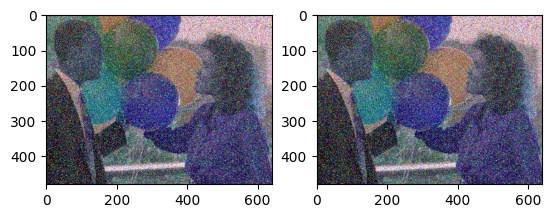

In [27]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('data/Noisy_img.png')

dst = cv2.fastNlMeansDenoisingColored(img,None,11,6,7,21)

plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(dst)
plt.show()

In [2]:
import sys
print(sys.path)

['/home/cm/.local/lib/python3.8/site-packages/libsvm', '/home/cm/Documents/Msu_Denver/3150/Final', '/home/cm/.vscode/extensions/ms-toolsai.jupyter-2022.11.1003412109/pythonFiles', '/home/cm/.vscode/extensions/ms-toolsai.jupyter-2022.11.1003412109/pythonFiles/lib/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/cm/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.8/dist-packages']
